# Backtesting Stochastic Oscilator Strategies

## Getting the Data

In [1]:
import sys
sys.path.append('../../')

In [2]:
from config.constants import *
from backtesting import Backtest, Strategy
from backtesting.test import EURUSD, SMA
from backtesting.lib import plot_heatmaps, resample_apply
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from util.ATR import *
from util.SMA import *
from util.plot_return import *
from util.Bollinger_bands import *
from util.load_data import *

In [3]:
XAUUSD = load_data()

In [4]:
XAUUSD['D1']

,Open,High,Low,Close,Volume
Time,,,,,
2007-01-01,635.679,637.103,635.006,635.943,604
2007-01-02,635.791,640.802,635.286,639.143,1282
2007-01-03,639.029,644.663,624.634,626.602,1302
2007-01-04,626.699,630.352,619.600,622.533,1365
2007-01-05,622.268,625.768,601.591,606.841,1284
...,...,...,...,...,...
2023-03-06,1852.255,1858.168,1845.015,1846.255,1380
2023-03-07,1846.225,1851.555,1812.655,1813.865,1380
2023-03-08,1813.855,1824.185,1809.248,1815.175,1379


In [5]:
XAUUSD['D1'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5043 entries, 2007-01-01 to 2023-03-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5043 non-null   float64
 1   High    5043 non-null   float64
 2   Low     5043 non-null   float64
 3   Close   5043 non-null   float64
 4   Volume  5043 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.4 KB


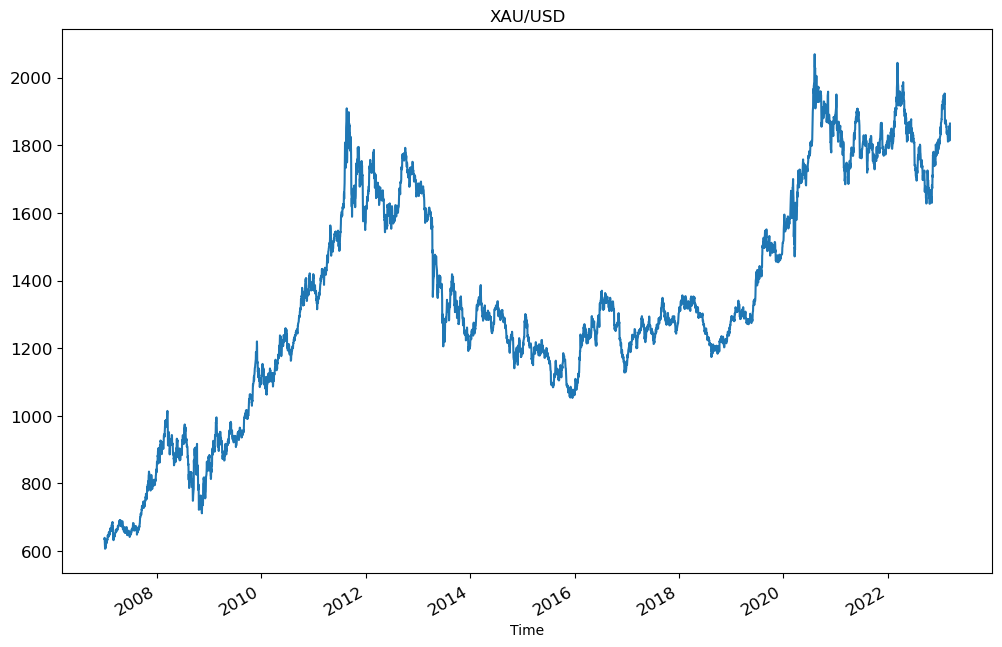

In [6]:
XAUUSD['D1'].Close.plot(figsize=(12, 8), title="XAU/USD", fontsize=12)
plt.show()

## Definde strategy

The __Stochastic Oscillator Indicator__ consists of two different lines/oscillators that are bounded by __0 and 100__: <br>
- __Fast Stochastic Indicator__ (%K line)
- __Slow Stochastic Indicator__ (%D line)

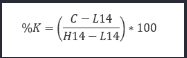

where: <br>
C = the most recent closing price <br>
L14: the minimum price in the last 14 days<br>
H14: the maximum price in the last 14 days

In [12]:
class SO(Strategy):
    periods = 14
    moving_av = 3
  

    def init(self):
        
        self.data.df["roll_low"] = self.data.df['Low'].rolling(self.periods).min()
        self.data.df["roll_high"] = self.data.df['High'].rolling(
            self.periods).max()
        self.data.df["K"] = (self.data.df.Close - self.data.df.roll_low) / \
            (self.data.df.roll_high - self.data.df.roll_low) * 100
        self.data.df["D"] = self.data.df.K.rolling(self.moving_av).mean()
        self.data.df["position"] = np.where(self.data.df["K"] > self.data.df["D"], 1, -1)

    def next(self):

        k = self.data.df.loc[self.data.df.index[-1], 'K']
        d = self.data.df.loc[self.data.df.index[-1], 'D']
        if k > d:
            if self.position.is_short :
                self.position.close()
            self.buy(size=1)
         

        if k < d:
            if self.position.is_long :
                self.position.close()
            self.sell(size=1)
      

## Backtesting

In [8]:
account_size = 20000

In [13]:
bt = Backtest(XAUUSD['H4'], SO, cash=account_size, margin=1/2000, )
result = bt.run()
result

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   99.938405
Equity Final [$]                    21251.847
Equity Peak [$]                     21711.038
Return [%]                           6.259235
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                    0.303838
Volatility (Ann.) [%]                2.858905
Sharpe Ratio                         0.106278
Sortino Ratio                        0.190687
Calmar Ratio                         0.028487
Max. Drawdown [%]                  -10.665985
Avg. Drawdown [%]                   -1.081828
Max. Drawdown Duration     3489 days 12:00:00
Avg. Drawdown Duration      151 days 09:00:00
# Trades                                25960
Win Rate [%]                        36.109399
Best Trade [%]                       9.444545
Worst Trade [%]                     -6.253184
Avg. Trade [%]                    

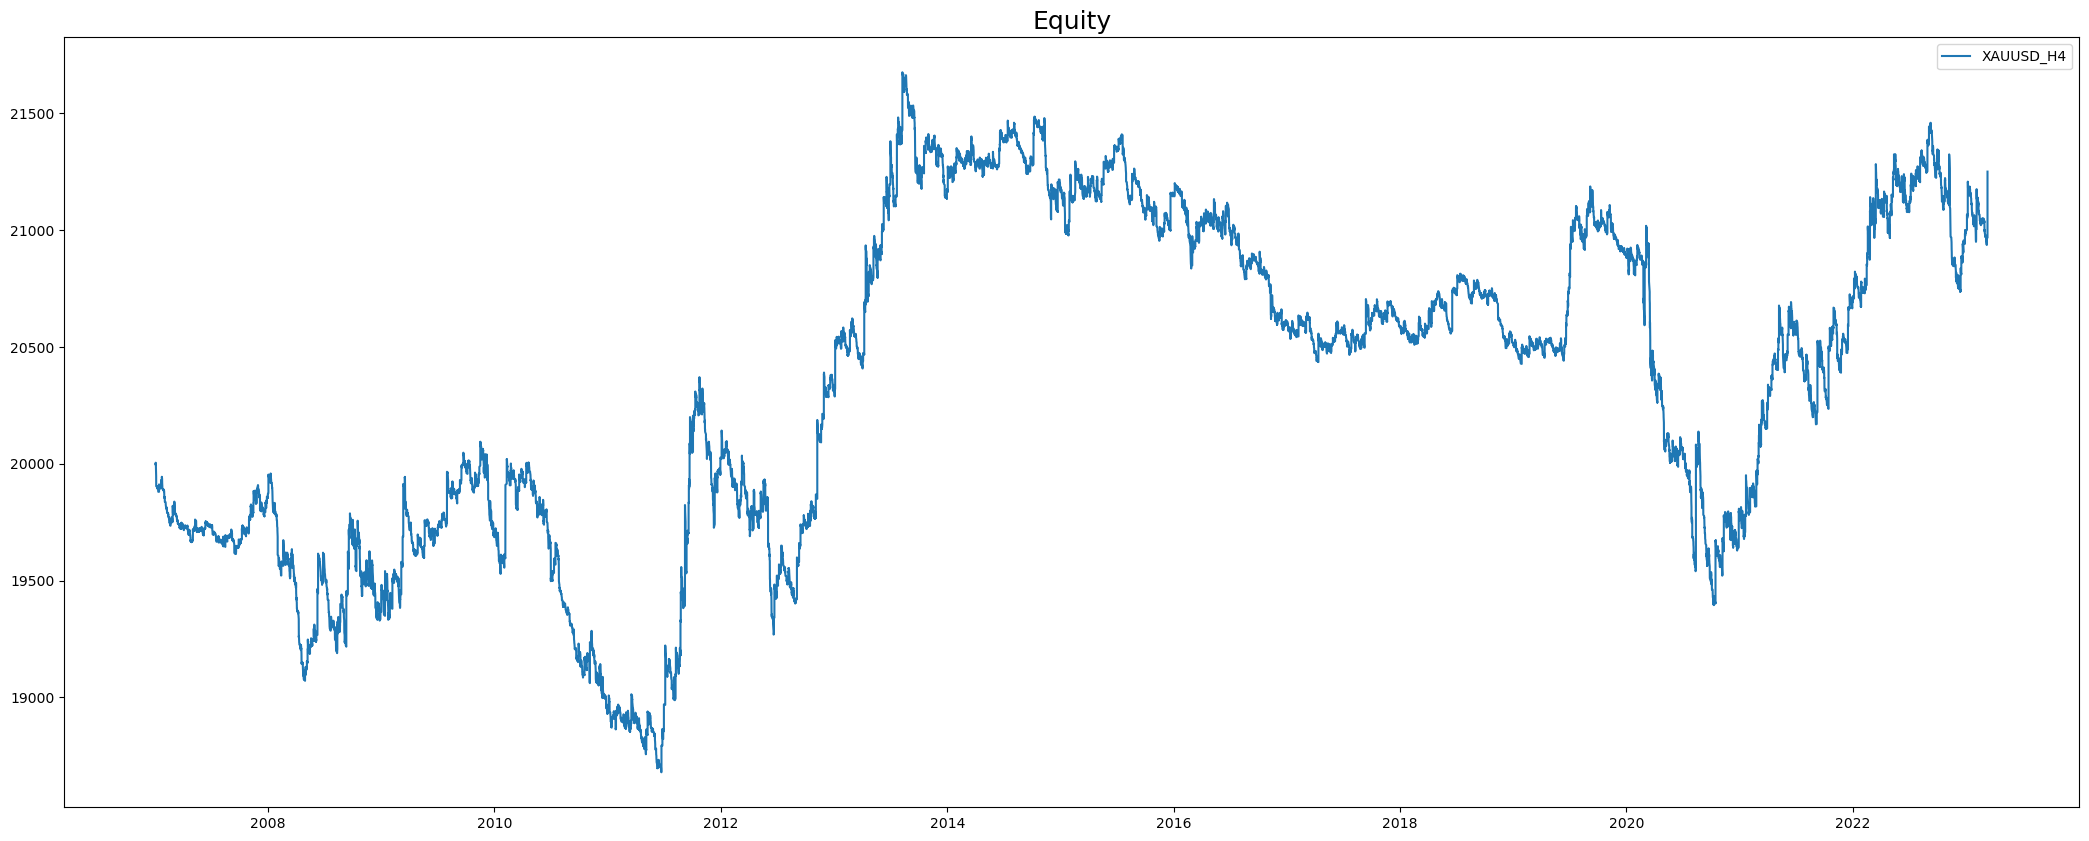

In [14]:
plot_return_trades(result['_trades'], 'XAUUSD_H4' , account_size)